In [7]:
%matplotlib inline ## no need of plt.show()
%reload_ext autoreload
%autoreload 2

UsageError: unrecognized arguments: ## no need of plt.show()


In [8]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import re, string, os, sys
from datetime import datetime
import warnings # To ignore any warnings (Good to have)
warnings.filterwarnings("ignore")

# viz
import seaborn as sns
from IPython.display import display, HTML, Image
from IPython.core.display import HTML 

# tree viz
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
import pydotplus

# machine learning
from sklearn.model_selection import train_test_split, ParameterGrid,KFold, StratifiedKFold
#from sklearn.cross_validation import KFold
from sklearn.linear_model import Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor, forest, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score,precision_recall_curve
from math import sqrt
from sklearn.base import BaseEstimator
from sklearn import preprocessing # label encoding
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,auc # auc
from sklearn.tree import DecisionTreeClassifier

## Data Summary

In [9]:
path="D:/case studies/wayfair/data/" # update this as path where you keep your data files while runnng notebook

In [10]:
missing_values = ["n/a", "na", "--","NA","NAN"] # checking NAs, NANs if present as string in dataframe 
train_df = pd.read_csv(path+"df_training_scholarjet.csv",na_values = missing_values)

test_df = pd.read_csv(path+"df_holdout_scholarjet.csv",na_values = missing_values)

In [11]:
train_df.shape, test_df.shape

((28126, 184), (30375, 182))

In [12]:
train_df.drop_duplicates().shape, test_df.drop_duplicates().shape

((28126, 184), (30375, 182))

In [13]:
dfs = [train_df, test_df]

In [14]:
for d in dfs:
    display(d.head(2))

,Unnamed: 0,cuid,convert_30,revenue_30,roll_up,currentstatus,companytypegroup,team,customersource,accrole,...,percemailopenedyearsixty,percemailclickedone,percemailclickedthreeone,percemailclickedseventhree,percemailclickedthirtyseven,percemailclickedsixtythirty,percemailclickedyearsixty,currentapplicability,numemaillist,dayssinceenrollment
0,1,20,0,0.0,Onboarding,Active,Business,US,External Application,None,...,0.00,0.0,0.0,0.0,0.190476,0.0,0.00,3.0,1.0,17
1,2,57,0,0.0,Onboarding,Active,Business,US,Internal Application,None,...,0.02,0.0,0.0,0.0,0.040000,0.0,0.02,3.0,1.0,70


,Unnamed: 0,cuid,roll_up,currentstatus,companytypegroup,team,customersource,accrole,num_employees,num_purchases_year,...,percemailopenedyearsixty,percemailclickedone,percemailclickedthreeone,percemailclickedseventhree,percemailclickedthirtyseven,percemailclickedsixtythirty,percemailclickedyearsixty,currentapplicability,numemaillist,dayssinceenrollment
0,0,16838,Onboarding,Enrolled,Business,US,Internal Application,None,1,1to2,...,0.025806,0.0,0.0,0.0,0.021739,0.012821,0.032258,5.0,2.0,86
1,1,532175,Onboarding,Enrolled,Business,US,Search - Paid,None,6to10,None,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,3


In [15]:
x = train_df.dtypes
y = test_df.dtypes

dtype = pd.DataFrame({"train_datatype":x, "test_datatype":y})
dtype.loc[dtype['train_datatype'] != dtype['test_datatype'],:] 

,train_datatype,test_datatype
convert_30,int64,NaN
revenue_30,float64,NaN


All Data types of training and test data exactly match

In [16]:
def missing_values(df):
    """
    This function gives the percentage and count of missing values for each column
    """
    df_na=df.isnull().sum().sort_values(ascending=False) #checks all NaNs
    df_na = df_na.reset_index().rename(columns = {'index': 'feat', 0: 'missing_vals'})
    df_na['missing_percent'] = round(df_na['missing_vals']/df.shape[0]*100,1)
    return df_na

In [17]:
train_na = missing_values(train_df)

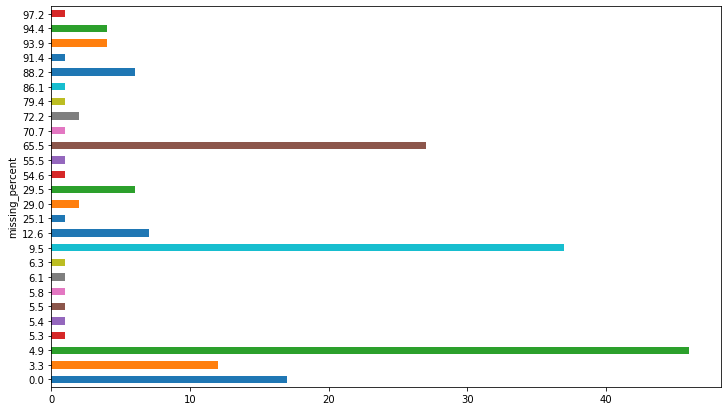

In [18]:
missing_dist= train_na.groupby("missing_percent").count().reset_index()
def plot_fi(fi): return fi.plot('missing_percent', 'feat', 'barh', figsize=(12,7), legend=False)
plot_fi(missing_dist)

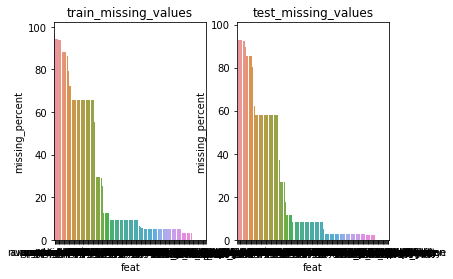

In [19]:
train_na = missing_values(train_df)
test_na = missing_values(test_df)
plt.subplot(121)  
ax = sns.barplot(x="feat",y="missing_percent",data=train_na).set_title("train_missing_values")
plt.subplot(122) 
ay = sns.barplot(x="feat",y="missing_percent",data=test_na).set_title("test_missing_values")
plt.show()

### How (dis)similar are my train and test data?

Understanding a scenario where your machine learning model can fail

In [21]:
def label_encoding(df):
    le = preprocessing.LabelEncoder()
    for column_name in df.columns:
        if df[column_name].dtype == object:
            df[column_name] = le.fit_transform(df[column_name])
        else:
            pass
    return df

In [22]:
train = train_df.copy()
test = test_df.copy()
train['is_train'] = 1
test['is_train'] = 0

train = train.fillna(-999)
test = test.fillna(-999)

train =  label_encoding(train)
test =  label_encoding(test)

#combining test and train data
df_combine = pd.concat([train, test], axis=0, ignore_index=True)

#dropping "target" variables as it is not present in the test
df_combine = df_combine.drop(["convert_30","revenue_30"], axis =1)

# dropping Unnamed and cuid variables as these are just primary keys (random numbers) not useful in the model
df_combine = df_combine.drop(["Unnamed: 0","cuid"], axis =1)

y = df_combine['is_train'].values #labels
x = df_combine.drop('is_train', axis=1).values #covariates or our independent variables
tst, trn = test.values, train.values

m = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)
predictions = np.zeros(y.shape) #creating an empty prediction array

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100) 
for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)): 
    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    m.fit(X_train, y_train)
    probs = m.predict_proba(X_test)[:, 1] 
    predictions[test_idx] = probs

In [23]:
print('ROC-AUC for train and test distributions:', roc_auc_score(y, predictions))

ROC-AUC for train and test distributions: 0.7400425861401472


Our classifier is able to classify the rows into train and test with good accuracy,as our AUC score is on higher side (greater than 0.7). This implies strong covariance shift between train and test.

### Variables causing train and test to be dissimilar ? 

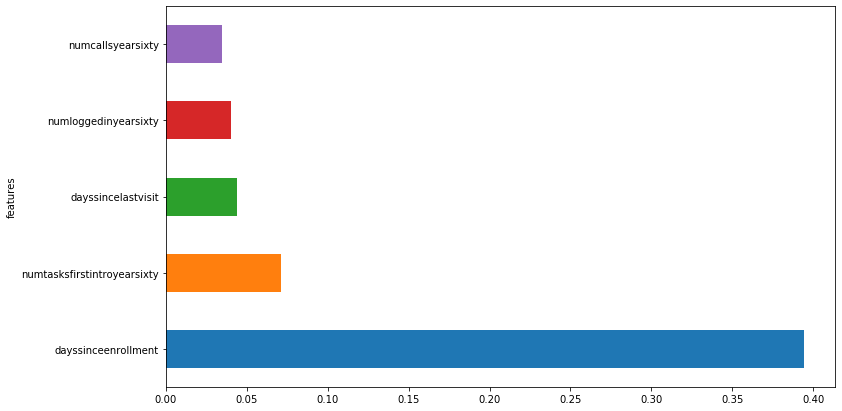

In [24]:
# Most important variables causing train and test to be dissimilar 
features = df_combine.drop('is_train', axis=1).columns
feat_importances = pd.Series(m.feature_importances_, index=features)
fi=pd.DataFrame({"features":features,"importance":m.feature_importances_})
fi=fi.sort_values('importance', ascending=False) ###sorting
def plot_fi(fi): return fi.plot('features', 'importance', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:5])

The following variables distributions is most dissimilar in train and test (in the order specified), this phenomenon is called **Covariate shift**

* **dayssinceenrollment**
* **numtasksfirstintroyearsixty** 

We need to have a close look at these features while building our models

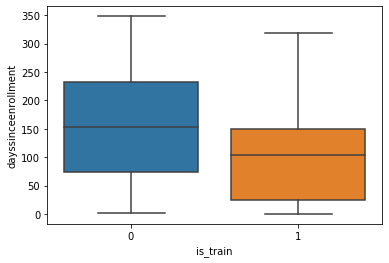

In [25]:
sns.boxplot(x="is_train", # swarm very slow
                  y="dayssinceenrollment", 
                  data=df_combine)

# EDA

### Target distribution

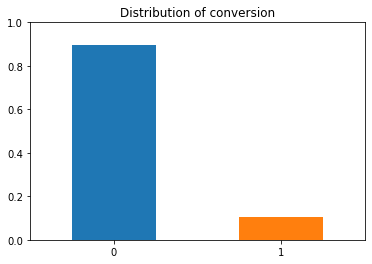

In [26]:
# CLass Imbalance
train_df.convert_30.value_counts(normalize=True).plot(kind='bar',ylim=(0,1),rot=1,title="Distribution of conversion")

In [27]:
for q in [0.0001,0.01, 0.1, 0.25, 0.5, 0.75, 0.95,0.99, 0.9999,1]:
    print(q,':',  train_df.revenue_30.loc[train_df.revenue_30!=0].quantile(q))

0.0001 : 4.947562
0.01 : 23.980000000000004
0.1 : 74.352
0.25 : 143.9875
0.5 : 309.005
0.75 : 764.9975000000001
0.95 : 2483.387975000003
0.99 : 5884.109657000001
0.9999 : 31928.85981990558
1 : 34986.6899


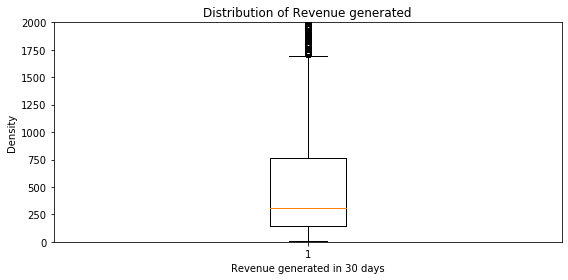

In [28]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.boxplot(train_df.revenue_30.loc[train_df.revenue_30!=0])
ax.set(xlabel='Revenue generated in 30 days',
       ylabel='Density',
       title='Distribution of Revenue generated')
ax.set_ybound(lower=0,upper = 2000)

fig.tight_layout()

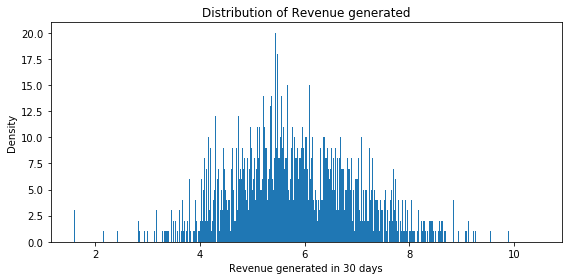

In [29]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.hist(np.log(train_df.revenue_30.loc[train_df.revenue_30!=0]), bins=1000)
ax.set(xlabel='Revenue generated in 30 days',
       ylabel='Density',
       title='Distribution of Revenue generated')

fig.tight_layout()

## Features Relation with Target Variable

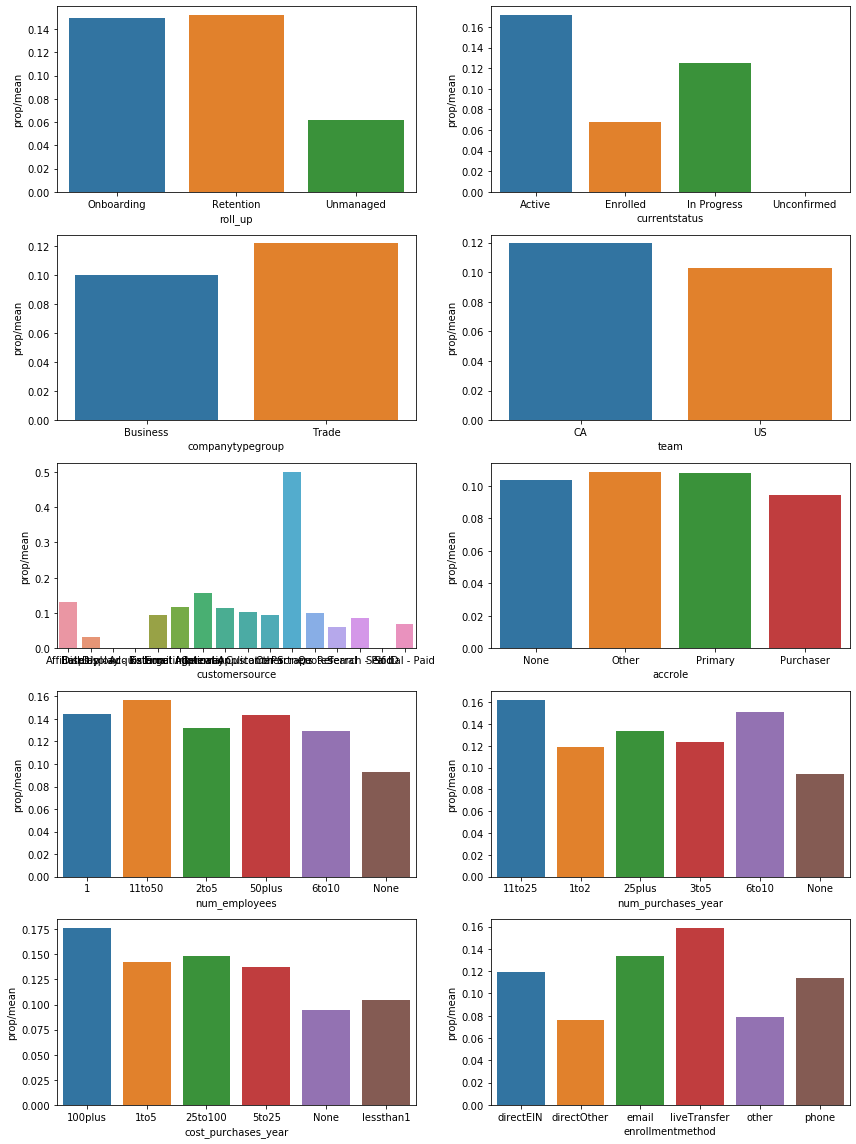

In [30]:
fig, axs = plt.subplots(5,2, figsize=(12,16))
ax = axs.flatten()

for i,x in enumerate(['roll_up', 'currentstatus', 'companytypegroup', 'team','customersource', 'accrole', 
                        'num_employees', 'num_purchases_year',
                        'cost_purchases_year', 'enrollmentmethod']):
    y="prop/mean"
    hue="convert_30"
    prop_df = (train_df[hue]
               .groupby(train_df[x])
               .mean()
               .rename(y)
               .reset_index())
    sns.barplot(x=x, y=y, data=prop_df, ax=ax[i])
    
fig.tight_layout()

Takeaway

* Active category favours customer purchase compared to Enrolled
* Unmanaged customers less likely to purchase


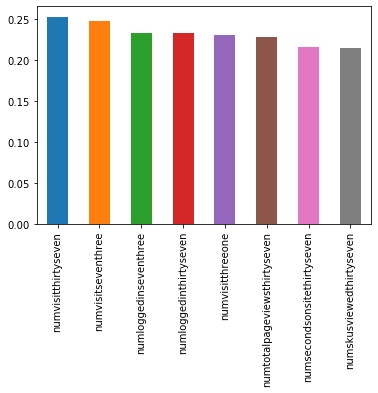

In [33]:
# numerical features

df = train_df.drop(['Unnamed: 0', 'cuid'], axis=1)
df_v2= pd.get_dummies(df)
corr = df_v2.corr()
corr['convert_30'].sort_values(ascending=False).iloc[2:10].plot(kind="bar")

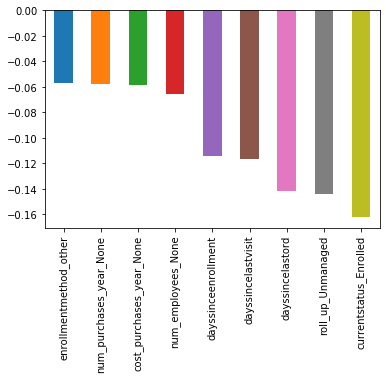

In [34]:
corr['convert_30'].sort_values(ascending=False).iloc[-20:-11].plot(kind="bar")

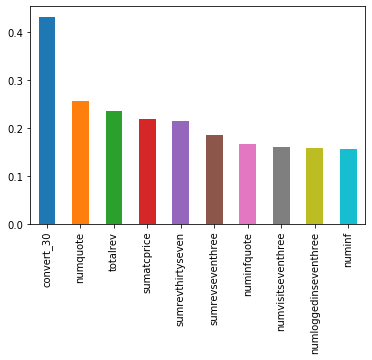

In [35]:
corr['revenue_30'].sort_values(ascending=False).iloc[1:11].plot(kind="bar")

In [36]:
for d in dfs:
    d.drop(["Unnamed: 0","cuid"], axis =1,inplace=True)

# Feature Engineering

In [37]:
for df in [train_df, test_df]: 
    df["activeonsite_3days"] = (df.numvisitone>0) | (df.numvisitthreeone>0) 
    df["activeonsite_7days"] = (df.numvisitone>0) | (df.numvisitthreeone>0) | (df.numvisitseventhree>0)
    df["activeonsite_30days"] = (df.numvisitone>0) | (df.numvisitthreeone>0) | (df.numvisitseventhree>0) |  (df.numvisitthirtyseven>0)
    list_name = ["numorderone","numorderthreeone","numorderseventhree","numorderthirtyseven"]
    list_ord = list_name + ["numordersixtythirty","numorderyearsixty"]
    df["monthly_cycle"] = (df.loc[:,list_name].fillna(0).sum(axis=1)>0) & (df.numordersixtythirty>0) &(df.numorderyearsixty>0)
    df["orders_per_month"] = ((df.loc[:,list_ord].fillna(0).sum(axis=1))/(df.dayssinceenrollment))*30
    df["ordered_last_month"] = df.loc[:,list_name].fillna(0).sum(axis=1)>0 # recency of purchase
    df["ordered_last_3days"] = (df.numorderone>0) | (df.numorderthreeone>0) 
    df["ordered_last_7days"] = (df.numorderone>0) | (df.numorderthreeone>0) | (df.numorderseventhree>0)
    list_name_email = ["numemailsone","numemailsthreeone","numemailsseventhree","numemailsthirtyseven"]
    df["email_BAM_last_month"] = df.loc[:,list_name_email].fillna(0).sum(axis=1)>0
    df["email_BAM_last_3days"] = (df.numemailsone>0) | (df.numemailsthreeone>0) 
    df["email_BAM_last_7days"] = (df.numemailsone>0) | (df.numemailsthreeone>0)  | (df.numemailsseventhree>0)
    list_name_calls = ["numcallsone","numcallsthreeone","numcallsseventhree","numcallsthirtyseven"]
    df["calls_last_month"] = df.loc[:,list_name_calls].fillna(0).sum(axis=1)>0
    df["calls_last_3days"] = (df.numcallsone>0) | (df.numcallsthreeone>0) 
    df["calls_last_7days"] = (df.numcallsone>0) | (df.numcallsthreeone>0)  | (df.numcallsseventhree>0)
    list_em_call = list_name_email + list_name_calls 
    df["calls&emails_last_month"] = df.loc[:,list_em_call].fillna(0).sum(axis=1)>0
    list_atc = ["numatcone","numatcthreeone","numatcseventhree","numatcthirtyseven"]
    df["atc&no_purchase_last_month"] = (df.loc[:,list_name].fillna(0).sum(axis=1)==0) & (df.loc[:,list_atc].fillna(0).sum(axis=1)>0)
    df["atc_last_month"] = df.loc[:,list_atc].fillna(0).sum(axis=1)>0
    df["atc_last_3days"] = (df.numatcone>0) | (df.numatcthreeone>0) 
    df["atc_last_7days"] = (df.numatcone>0) | (df.numatcthreeone>0)  | (df.numatcseventhree>0)
    list_name_sku = ["numskusviewedone","numskusviewedthreeone","numskusviewedseventhree","numskusviewedthirtyseven"]
    df["sku_last_month"] = df.loc[:,list_name_sku].fillna(0).sum(axis=1)>0
    df["sku_last_3days"] = (df.numskusviewedone>0) | (df.numskusviewedthreeone>0) 
    df["sku_last_7days"] = (df.numskusviewedone>0) | (df.numskusviewedthreeone>0)  | (df.numskusviewedseventhree>0)
    list_name_search = [ "numsearchtermsone","numsearchtermsthreeone","numsearchtermsseventhree","numsearchtermsthirtyseven"]
    df["search_last_month"] = df.loc[:,list_name_search].fillna(0).sum(axis=1)>0
    df["search_last_3days"] = (df.numsearchtermsone>0) | (df.numsearchtermsthreeone>0) 
    df["search_last_7days"] = (df.numsearchtermsone>0) | (df.numsearchtermsthreeone>0)  | (df.numsearchtermsseventhree>0)
    list_name_tasks = ["numtasksfirstintroone","numtasksfirstintrothreeone","numtasksfirstintroseventhree","numtasksfirstintrothirtyseven"]
    df["tasks_last_month"] = df.loc[:,list_name_tasks].fillna(0).sum(axis=1)>0
    df["tasks_last_3days"] = (df.numtasksfirstintroone>0) | (df.numtasksfirstintrothreeone>0) 
    df["tasks_last_7days"] = (df.numtasksfirstintroone>0) | (df.numtasksfirstintrothreeone>0)  | (df.numtasksfirstintroseventhree>0)
    list_or_7 = ["numorderone","numorderthreeone","numorderseventhree"]
    list_act = ["numskusviewedone","numskusviewedthreeone","numskusviewedseventhree",
            "numsearchtermsone","numsearchtermsthreeone","numsearchtermsseventhree"]
    df["activity&no_purchase_7days"] = (df.loc[:,list_or_7].fillna(0).sum(axis=1)==0) & (df.loc[:,list_act].fillna(0).sum(axis=1)>0)


# Data Preprocessing

## Missing values

#### Adding is_na features
add a {name}_na column which specifies if the data was missing.

In [38]:
for d in [train_df, test_df]:  
    missing = d.isna().sum()
    cols_missing = list(missing[missing > 0].index)
    print(len(cols_missing))
    for name in cols_missing:
        d[name + '_na'] = pd.isnull(d[name])

168
167


Imputing missing values

In [39]:
for df in [train_df, test_df]: 
    df.fillna(value=-100,inplace=True) # rest we replace by a constant value, as missing data has its own meaning # 0 already present

### Boolean to Int

In [40]:
def bool_to_int(df):
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col]*1

In [41]:
bool_to_int(train_df)
bool_to_int(test_df)

In [42]:
train_df.shape, test_df.shape

((28126, 379), (30375, 376))

## Categorical variables

### Mean target encoding - Regularized

In [43]:
def target_encoder_regularized(train, test, cols_encode, target, folds = 5):
    """
    Mean regularized target encoding based on kfold
    
    """
    
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    #     set_trace()
    test_copy = test.reset_index().copy()
    train_copy = train.reset_index().copy()
    
    for col in cols_encode:      
        encoded_column = col + "_mean_target"
        train_copy[encoded_column] = np.zeros(len(train_copy))
        test_copy[encoded_column] = np.zeros(len(test_copy))
        
        for train_index, val_index in kf.split(train):

            mean_target =  train_copy.loc[train_index].groupby(col)[target].mean()

            train_copy.loc[val_index,encoded_column] = train_copy.loc[val_index, col].map(mean_target)
        
        global_mean = train_copy[target].mean()
        train_copy[encoded_column].fillna(global_mean, inplace=True)
        
        # making test encoding using full training data 
        test_copy[encoded_column] = test_copy[col].map(train_copy.groupby(col)[target].mean())
        test_copy[encoded_column].fillna(global_mean, inplace=True)
            
    return train_copy, test_copy

In [44]:
cat_columns = list(train_df.select_dtypes(include='object').columns) # 10 columns
cat_columns

['roll_up',
 'currentstatus',
 'companytypegroup',
 'team',
 'customersource',
 'accrole',
 'num_employees',
 'num_purchases_year',
 'cost_purchases_year',
 'enrollmentmethod']

In [45]:
df_train, df_test = target_encoder_regularized(train_df, test_df, cat_columns,target='convert_30', folds=5)

In [46]:
def drop_columns(df_train, df_test, cols):
    """
    Drop a list of columns from both train df and test df
    """
    
    df_train.drop(cols, inplace=True, axis=1)
    df_test.drop(cols, inplace=True, axis=1)

In [47]:
drop_columns(df_train, df_test, cat_columns+["index"])

In [48]:
df_train['orders_per_month'].replace(np.inf,-200,inplace=True)
df_test['orders_per_month'].replace(np.inf,-200,inplace=True)

In [50]:
df_train.shape, df_test.shape 

((28126, 379), (30375, 376))

# Model building

In [51]:
X = df_train.copy().drop(['convert_30','revenue_30'], axis=1) # removing target variables
y = df_train.copy()['convert_30']

In [52]:
X.shape, y.shape, df_test.shape

((28126, 377), (28126,), (30375, 376))

# Feature Selection

In [53]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(random_state=0)

m.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### Default sklearn feature importance

In [54]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=True)

In [55]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,9), legend=False)

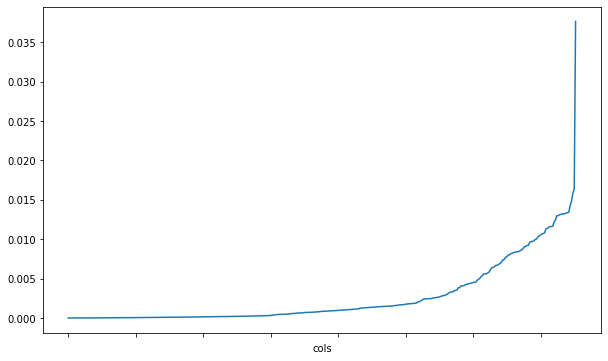

In [57]:
fi = rf_feat_importance(m, X)
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

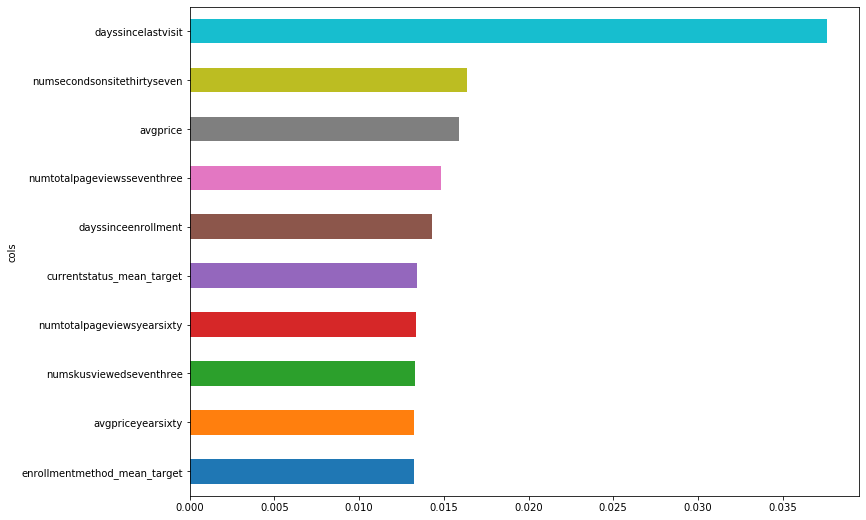

In [61]:
plot_fi(fi[-10:]);

In [62]:
imp_columns = list(fi.loc[fi.imp>=0.002,"cols"])
imp_columns

['numcallsthreeone',
 'numsearchtermsone',
 'currentapplicability_na',
 'numemaillist_na',
 'percentresolved',
 'sku_last_7days',
 'numordersixtythirty',
 'numproblem',
 'numinf',
 'numtasksfirstintrothirtyseven',
 'atc_last_3days',
 'numinfconnect',
 'numsearchtermsthreeone',
 'numorderthirtyseven',
 'numother',
 'totalcalldurationthreeone',
 'numtasksfirstintroyearsixty',
 'avgquoteprice',
 'numcallsthirtyseven',
 'numemailssixtythirty',
 'numreturn',
 'numinfphone',
 'percsecondsinbound',
 'percemailopenedone',
 'totalcalldurationseventhree',
 'sumrevthirtyseven',
 'numcallssixtythirty',
 'sumrevsixtythirty',
 'numemailsthirtyseven',
 'percemailclickedthreeone',
 'numideaboardsixtythirty',
 'numorderyearsixty',
 'avgpriceone',
 'numloggedinthreeone',
 'numsearchtermsseventhree',
 'numselforder',
 'numatcsixtythirty',
 'numvisitone',
 'totalcalldurationsixtythirty',
 'sumrevyearsixty',
 'numskusviewedone',
 'numemailsyearsixty',
 'numatcthirtyseven',
 'numloggedinone',
 'numemaillist

In [63]:
X = X[imp_columns]
df_test = df_test[imp_columns] 

In [64]:
from xgboost import XGBClassifier

m = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_delta_step=0,
                  max_depth=4, min_child_weight=3, missing=-999, n_estimators=100,
                  n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
                  subsample=0.75)
    

m.fit(X, y)  
prediction_score = m.predict_proba(df_test)[:,1]

In [65]:
df_test["prediction"] = prediction_score

# Model Interpretation

In [66]:
import shap

In [67]:
# print the JS visualization code to the notebook
shap.initjs()

In [68]:
X_sample = X.sample(n=5000)

**Caution**
I am running this only for 5000 sample observations from validation set as this is very slow to run on whole dataset. But result from 1000 observations should give us good idea about actual scenatio

In [69]:
X_sample.shape

(5000, 118)

In [70]:
# -- this chunk will take time to run. so commenting it
explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(X_sample)

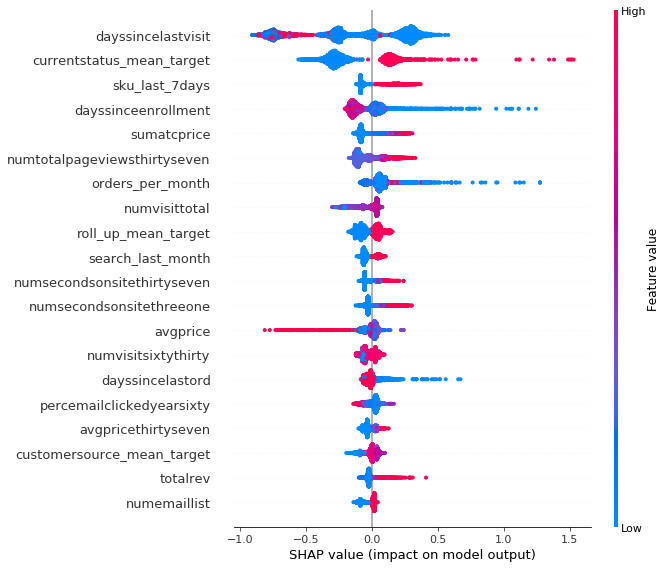

In [71]:
shap.summary_plot(shap_values, X_sample) # this shows value impact from each variable for each row

**Takeaways**
* higher values which is 1000, shows that it makes prediction towards 0
* Current status mean for higher values it goes towards 1
* Low days since enrollment has positive impact towards 1
* If Sku viewed in last month then impact towards 1
* These clusters are due to high values of 0 in the dataset

### Shap dependency plots
To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. 

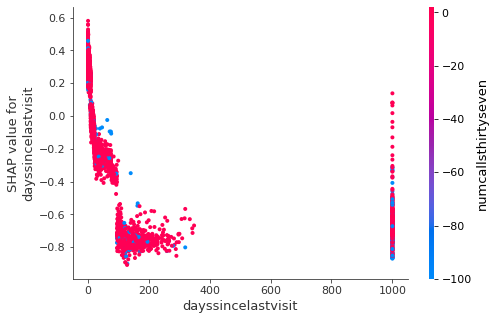

In [73]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("dayssincelastvisit",
                     shap_values,
                     X_sample,
                     interaction_index=18)

With increase in dayssince last visit the likelihood of buying decreases

### Individual contributions SHAP
With SHAP we can also explain any one observation of our interest and see which drove the prediction

In [74]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [75]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sample.iloc[0,:])

**Takeaways**
* Days since last visit trying to push the towards positive, as it is very less so visit more
* Orders per month featured also is good, higher orders in this observation pushing towards 1

In [59]:
df_test.to_csv("class_prediction_final.csv")

# Regression

In [76]:
X = df_train.copy().drop(['convert_30','revenue_30'], axis=1) # removing target variables
y = df_train.copy()['revenue_30']

In [77]:
y.min(), y.max(),y.mean()

(0.0, 34986.6899, 75.03899719476578)

In [78]:
X.shape, y.shape, df_test.shape

((28126, 377), (28126,), (30375, 119))

In [79]:
X = X[imp_columns]
df_test = df_test[imp_columns] 

In [80]:
X.shape, y.shape, df_test.shape

((28126, 118), (28126,), (30375, 118))

In [81]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import f1_score, recall_score, precision_score


m = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_delta_step=0,
                  max_depth=4, min_child_weight=3, missing=-999, n_estimators=100,
                  n_jobs=1, nthread=4, random_state=0,
                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
                  subsample=0.75)
    

m.fit(X, y)  
prediction_score = m.predict(df_test)

In [82]:
m = XGBRegressor()
    
m.fit(X, y)  
prediction_score = m.predict(df_test)

In [83]:
prediction_score.min(), prediction_score.max(),prediction_score.mean()

(-38.731644, 15082.964, 65.66984)

In [84]:
df_test["rev_prediction"] = prediction_score

In [164]:
df_test.to_csv("reg_prediction_final.csv",index=False)